<a href="https://colab.research.google.com/github/carolflyjs/cs230/blob/master/Glove_LSTM_Model_64d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%run "/content/drive/My Drive/Colab Notebooks/Data_Processing_v2.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"

     |████████████████████████████████| 1.9MB 3.4MB/s 


Using TensorFlow backend.


load_file(path, delimiter=","): return df
data_prep(df, x_columns, y_columns): return X_train, Y_train
removeSpellingErrors(df): return new_df
tokenize_and_pad(X_train), return X_train_padded, max_value, vocab_size, tokenizer
store_weights(mode, model_name, path="/content/drive/My Drive/cs230/")
load_weights(mode, model_name, path="/content/drive/My Drive/cs230/")
join_histories_and_plot(*histories)

load_embedding_matrix(embeddings_index, vocab_size, embedding_dim, word_index)
embedding_index = pre-trained embedding dictionary with key being the word and value being the embedding scores
vocab_size = total number of unique tokens in the training data
embedding_dim = dimension used in the embedding_index for each token
word_index = token dictionary with key being the word and value being the token



In [2]:
glove_file = keras.utils.get_file("glove.6B.zip", "http://nlp.stanford.edu/data/glove.6B.zip", extract=True)

862183424/862182613 [==============================] - 387s 0us/step


In [0]:
def load_glove(glove_dir, glove_file_name):
    embeddings_index = {}
    f = open(os.path.join(glove_dir, glove_file_name))
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except:
            pass
    f.close()
    return embeddings_index

In [0]:
embeddings_index = load_glove("/root/.keras/datasets/", "glove.6B.100d.txt")
embedding_dim = 100

In [0]:
def load_embedding_matrix(embeddings_index, vocab_size, embedding_dim, word_index):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    not_found = []
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            not_found.append((word, i))
    return embedding_matrix, not_found

In [6]:
def build_glove_model(max_value, vocab_size, optimizer, embedding_matrix, embedding_dim = 100, LSTM_dim = 128): 
    X_input = Input(shape=(max_value * 2,), dtype="int32")
    X = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix])(X_input)
    X = LSTM(LSTM_dim, kernel_regularizer=keras.regularizers.l2(0.01))(X)
    # X = keras.layers.Flatten("channels_last")(X)
    X = Dense(5, activation="softmax")(X)

    model = Model(inputs=[X_input], outputs=X)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    model.summary()

    return model

embedding_matrix, _ = load_embedding_matrix(embeddings_index, vocab_size, embedding_dim, tokenizer.word_index)
optimizer = keras.optimizers.Adagrad(lr=0.035)
model = build_glove_model(max_value=max_value, vocab_size=vocab_size, optimizer=optimizer, embedding_matrix=embedding_matrix, embedding_dim=embedding_dim, LSTM_dim=64)












Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 16, 100)           351700    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 394,265
Trainable params: 394,265
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(X_train_tokenized, Y_train, validation_data=(X_dev_tokenized, Y_dev), epochs=50, batch_size=32, class_weight=class_weight) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 290693 samples, validate on 18723 samples
Epoch 1/50
290693/290693 [==============================] - 211s 727us/step - loss: 1.0760 - categorical_accuracy: 0.8229 - val_loss: 0.4825 - val_categorical_accuracy: 0.8670
Epoch 2/50
290693/290693 [==============================] - 211s 725us/step - loss: 0.6639 - categorical_accuracy: 0.8987 - val_loss: 0.3677 - val_categorical_accuracy: 0.9052
Epoch 3/50
290693/290693 [==============================] - 210s 724us/step - loss: 0.5444 - categorical_accuracy: 0.9214 - val_loss: 0.3574 - val_categorical_accuracy: 0.9077
Epoch 4/50
290693/290693 [==============================] - 210s 723us/step - loss: 0.4721 - categorical_accuracy: 0.9351 - val_loss: 0.3015 - val_categorical_accuracy: 0.9311
Epoch 5/50
290693/290693 [==============================] - 212s 730us/step - loss: 0.4213 - categorical_accuracy: 0.9434 - val_loss: 0.2820 - val_ca

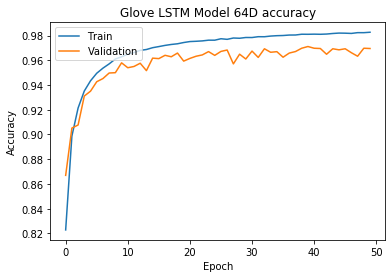

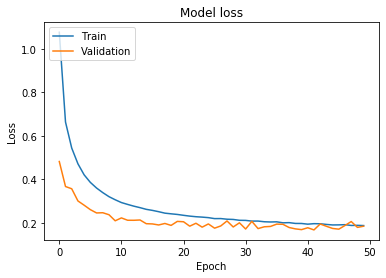

In [8]:
combined = join_histories_and_plot("Glove LSTM Model 64D", history)

In [9]:
getConfusionMatrix(model, X_test_tokenized, Y_test)

[[ 926    0    9   10    8]
 [   2 1069    0    6    5]
 [   0    0  192   13    1]
 [   1    0    5  199    0]
 [  17    5    3    9  626]]


In [10]:
model.evaluate(x=X_test_tokenized, y=Y_test)

3106/3106 [==============================] - 0s 110us/step


[0.17456916194344366, 0.96973599484868]

In [16]:
  reverse_class_dict = {
      0: "BT",
      1: "NT",
      2: "NPT",
      3: "PT",
      4: "URT"
  }
  Y_predicted = model.predict(X_test_tokenized)
  print("Source Term, Target Term, Ground Truth, Prediction \n")
  for i in range(31, 50):
    y_predict_scores = Y_predicted[i, :]
    y_predict_index = np.argmax(y_predict_scores)
    y_predict = reverse_class_dict.get(y_predict_index)
    y_actual = reverse_class_dict.get(np.argmax(Y_test[i]))
    print(X_test_raw.iloc[i, 0] + "," + X_test_raw.iloc[i, 1] + "," + y_actual + "," + y_predict, y_predict_scores[y_predict_index])

Source Term, Target Term, Ground Truth, Prediction 

learning and development coordinator,field officer sales,URT,URT 0.9997348
manager hrd & ga,national human resources manager,NT,NT 0.9999964
auditor senior tax,accounting auditor,BT,BT 0.99991906
head information technology,director technology operations,NT,NT 0.9999366
marketing member team,freelance marketing,NT,NT 0.96337134
teacher,english second language tutor,NT,NT 0.99989307
hr unit head,director of recruitment,NT,NT 0.9999989
information technology management,information technology section manager,NT,NT 0.9949884
saleswoman,business sales representative,NT,NT 0.9991715
onsite project manager,captain project,BT,BT 0.9999541
administrative assistant,desk front receptionist,NT,NT 0.99817085
contractor information technology,information technology specialist,BT,BT 0.99642617
it infrastructure architect,information technology system architect,PT,PT 0.9997172
lead information technology specialist,lead information technology specia